<a href="https://colab.research.google.com/github/Sal4321/Survival-Predicition-using-Autoencoder-and-AFT-/blob/main/variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, GaussianNoise,BatchNormalization
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import GaussianNoise
import tensorflow_probability as tfp
from tensorflow.keras import Sequential, Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from lifelines.utils import concordance_index

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

In [37]:
pip install lifelines

     |████████████████████████████████| 358kB 8.1MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-cp37-none-any.whl size=4050 sha256=54059f57e773fe5923304dbb8dd72d98150c40292ac77556c9ad482befad26ab
  Stored in directory: /root/.cache/pip/wheels/dc/68/dc/91321c55fba449755524481854f5be70d41912b8f886f908bb
Successfully built autograd-gamma


In [ ]:
!pip install lifelines

In [39]:
#load the clinical_data
clinical_data=pd.read_csv("out.csv")    

In [40]:
clinical_data.head()

,attrib_name,years_to_birth,Tumor_purity,histological_type,gender,radiation_therapy,race,ethnicity,overall_survival,status
0,TCGA.02.0001,44,0.7876,untreatedprimary(denovo)gbm,female,yes,white,nothispanicorlatino,358.0,1.0
1,TCGA.02.0003,50,0.9850,untreatedprimary(denovo)gbm,male,yes,white,nothispanicorlatino,144.0,1.0
2,TCGA.02.0004,59,0.7937,untreatedprimary(denovo)gbm,male,yes,white,nothispanicorlatino,345.0,1.0
3,TCGA.02.0007,40,0.9850,treatedprimarygbm,female,yes,white,nothispanicorlatino,705.0,1.0
4,TCGA.02.0009,61,0.9850,untreatedprimary(denovo)gbm,female,yes,white,nothispanicorlatino,322.0,1.0


In [41]:
tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

data=pd.read_excel('RNA_seq_1.xlsx')
#data2=pd.read_excel('C://Personal//Unf Course Folder//Spring 2021//Applied Predictive Modelling//RNA_seq_2.xlsx')
data=data.T
sample_names=list(data.index)
sample_names=sample_names[1:]
feature=data.iloc[0,:]
data=data.drop(index='attrib_name')
data.columns=feature
#check if we have null values
isnull=pd.isnull(data)
countmissing=isnull.sum(axis=0)
total_missing=countmissing.sum()
#There are 191 missing values from ["RAC1"] gene. I will drop this column
data=data.drop(['RAC1'],axis=1)

#convert dataframe to numpy array
X=np.asarray(data).astype(np.float32)

In [42]:
X=np.delete(X,[372,458,462],axis=0)

In [43]:
X.shape

(525, 4570)

In [44]:
X_temp, X_test, y_temp, y_test = train_test_split(X, X, test_size=0.20, random_state=42)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.10, random_state=42)

In [46]:
X_test.shape

(105, 4570)

In [47]:
train_ds = tf.data.Dataset.from_tensor_slices(X_train)
test_ds = tf.data.Dataset.from_tensor_slices(X_test)
val_ds = tf.data.Dataset.from_tensor_slices(X_val)


In [48]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
train_ds

<BatchDataset shapes: (None, 4570), types: tf.float32>

In [49]:
def get_prior(num_modes, latent_dim):
    """
    This function should create an instance of a MixtureSameFamily distribution 
    according to the above specification. 
    The function takes the num_modes and latent_dim as arguments, which should 
    be used to define the distribution.
    Your function should then return the distribution instance.
    """
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=tf.ones(num_modes)/num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
                                    loc=tf.Variable(tf.random.normal([num_modes, latent_dim])),
                                    scale_diag=tfp.util.TransformedVariable(tf.ones((num_modes,latent_dim), dtype='float32'), bijector=tfb.Softplus(), dtype='float32')))
    return prior

In [50]:
prior = get_prior(num_modes=2, latent_dim=10)
prior
#prior=tf.random.normal([2,50])

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[10] dtype=float32>

In [51]:

def get_kl_regularizer(prior_distribution):
    """
    This function should create an instance of the KLDivergenceRegularizer 
    according to the above specification. 
    The function takes the prior_distribution, which should be used to define 
    the distribution.
    Your function should then return the KLDivergenceRegularizer instance.
    """
    regularizer=tfpl.KLDivergenceRegularizer(prior_distribution,use_exact_kl=False,weight=1.0,test_points_fn=lambda q:q.sample(3),test_points_reduce_axis=(0,1))
    return regularizer

In [52]:
kl_regularizer = get_kl_regularizer(prior)  

In [53]:
def get_encoder(latent_dim, kl_regularizer):
    """
    This function should build an encoder model according to the above specification. 
    The function takes latent_dim and kl_regularizer as arguments, which should be
    used to define the model.
    Your function should return the encoder model.
    """
    model=Sequential([Dense(units=100,activation='relu',input_shape=(4570,)),
                      Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
                      tfpl.MultivariateNormalTriL(latent_dim,activity_regularizer=kl_regularizer)
                     ])
    return model

In [54]:
encoder = get_encoder(latent_dim=10, kl_regularizer=kl_regularizer)
encoder

In [55]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               457100    
_________________________________________________________________
dense_4 (Dense)              (None, 65)                6565      
_________________________________________________________________
multivariate_normal_tri_l_1  multiple                  40        
Total params: 463,705
Trainable params: 463,705
Non-trainable params: 0
_________________________________________________________________


In [56]:
def get_decoder(latent_dim):
    """
    This function should build a CNN decoder model according to the above specification. 
    The function takes latent_dim as an argument, which should be used to define the model.
    Your function should return the decoder model.
    """
    decoder=Sequential([Dense(100,activation='relu',input_shape=(latent_dim,)),
                        tfpl.IndependentBernoulli((4570,))
                       ])
    return decoder

In [57]:
decoder = get_decoder(latent_dim=10)

In [58]:
encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               457100    
_________________________________________________________________
dense_4 (Dense)              (None, 65)                6565      
_________________________________________________________________
multivariate_normal_tri_l_1  multiple                  40        
Total params: 463,705
Trainable params: 463,705
Non-trainable params: 0
_________________________________________________________________


In [59]:
def reconstruction_loss(batch_of_data, decoding_dist):
    """
    This function should compute and return the average expected reconstruction loss,
    as defined above.
    The function takes batch_of_data (Tensor containing a batch of input data to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images))
    

In [60]:

vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss, metrics=["Accuracy"])
vae

In [61]:
  history=vae.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
12/12 [==============================] - 5s 101ms/step - loss: 21.0050 - accuracy: 0.0000e+00 - val_loss: 0.8480 - val_accuracy: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3914 - accuracy: 0.0000e+00 - val_loss: 0.7777 - val_accuracy: 0.0000e+00
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3885 - accuracy: 0.0000e+00 - val_loss: 0.8505 - val_accuracy: 0.0000e+00
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3874 - accuracy: 0.0000e+00 - val_loss: 0.7565 - val_accuracy: 0.0000e+00
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3830 - accuracy: 0.0000e+00 - val_loss: 0.7391 - val_accuracy: 0.0000e+00
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 0.3686 - accuracy: 0.0000e+00 - val_loss: 0.7765 - val_accuracy: 0.0000e+00
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 0.3673 - accuracy: 0.0000e+0

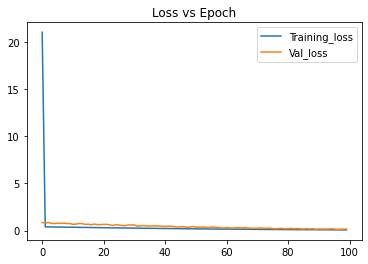

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training_loss','Val_loss'])
plt.title('Loss vs Epoch')
plt.savefig('Loss_var')

In [ ]:
def reconstruct(encoder, decoder, batch_of_genes):
    """
    This function should compute reconstructions of the batch_of_genes according
    to the above instructions.
    The function takes the encoder, decoder and batch_of_genes as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    encodings = encoder(batch_of_genes)
    decodings=decoder(encodings.mean()).mean()
    
    return decodings
    
    

In [63]:
b=X_test[0:2,:]
b.shape
encodings=encoder(X)

In [64]:
encodings

<tfp.distributions.MultivariateNormalTriL 'sequential_2_multivariate_normal_tri_l_1_MultivariateNormalTriL_MultivariateNormalTriL' batch_shape=[525] event_shape=[10] dtype=float32>

In [65]:
features=encodings.sample().numpy()

In [66]:
features=pd.DataFrame(features)
features

,0,1,2,3,4,5,6,7,8,9
0,-0.750713,-0.264170,-1.732696,-0.382637,0.130948,-0.286804,-0.537604,-0.520043,1.359504,-0.260532
1,-0.126037,0.113939,-1.228748,-0.805015,-0.318522,1.375131,0.330537,-0.522685,0.670305,-0.450734
2,-1.189679,0.196028,0.622810,-0.449176,0.555818,0.241020,1.850960,0.942064,1.134398,-0.056417
3,-0.383453,-0.758757,0.542443,-2.132998,-0.100129,1.458055,-1.602010,-0.695038,0.506275,-2.021970
4,-0.858441,0.263830,0.561312,1.158930,-0.390611,-0.760670,-0.401866,-1.306166,1.870169,1.235928
...,...,...,...,...,...,...,...,...,...,...
520,1.207107,0.306343,-0.184196,-0.256031,0.270494,0.280542,-1.256153,0.236448,1.177843,0.056330
521,-0.650870,0.595766,-0.045400,0.053234,-0.305393,0.438365,-1.324404,-0.299118,1.287890,1.326913
522,-0.101025,-0.214929,-1.358341,0.904105,-1.298545,0.933941,-2.077636,0.339750,-0.066728,0.556046
523,0.106782,-0.657348,-0.895035,0.426090,-0.496813,-0.639957,0.126763,-0.857128,0.137586,1.195022


In [67]:
features.columns=["feature1","feature2","feature3","feature4","feature5","feature6","feature7","feature8","feature9","feature10"]

In [68]:
scalar=StandardScaler().fit(features)
scaled=pd.DataFrame((scalar.fit_transform(features)))



In [69]:
scaled.columns=features.columns

In [70]:
finaldata=pd.concat([clinical_data,scaled],axis=1)

In [71]:
finaldata

,attrib_name,years_to_birth,Tumor_purity,histological_type,gender,radiation_therapy,race,ethnicity,overall_survival,status,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10
0,TCGA.02.0001,44,0.7876,untreatedprimary(denovo)gbm,female,yes,white,nothispanicorlatino,358.0,1.0,-0.912300,0.021216,-1.580327,-0.141815,0.536153,-0.079910,-0.280532,-0.560789,1.058499,-0.334538
1,TCGA.02.0003,50,0.9850,untreatedprimary(denovo)gbm,male,yes,white,nothispanicorlatino,144.0,1.0,-0.244209,0.476432,-1.036794,-0.588086,0.037263,1.879867,0.700296,-0.563669,0.241410,-0.530486
2,TCGA.02.0004,59,0.7937,untreatedprimary(denovo)gbm,male,yes,white,nothispanicorlatino,345.0,1.0,-1.381774,0.575262,0.960204,-0.212119,1.007737,0.542507,2.418075,1.033209,0.791622,-0.124257
3,TCGA.02.0007,40,0.9850,treatedprimarygbm,female,yes,white,nothispanicorlatino,705.0,1.0,-0.519516,-0.574232,0.873524,-1.991187,0.279669,1.977652,-1.483102,-0.751569,0.046941,-2.149184
4,TCGA.02.0009,61,0.9850,untreatedprimary(denovo)gbm,female,yes,white,nothispanicorlatino,322.0,1.0,-1.027515,0.656891,0.893875,1.486950,-0.042752,-0.638698,-0.127175,-1.417825,1.663926,1.207126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,TCGA.76.6193,78,0.6246,untreatedprimary(denovo)gbm,male,yes,NaN,NaN,82.0,1.0,1.181589,0.708074,0.089808,-0.008048,0.691041,0.589113,-1.092351,0.263943,0.843129,-0.008105
521,TCGA.76.6282,63,0.7034,untreatedprimary(denovo)gbm,male,yes,white,nothispanicorlatino,519.0,1.0,-0.805518,1.056518,0.239507,0.318711,0.051836,0.775219,-1.169461,-0.319936,0.973596,1.300858
522,TCGA.76.6285,64,0.7913,untreatedprimary(denovo)gbm,female,no,white,NaN,254.0,1.0,-0.217459,0.080498,-1.176566,1.217711,-1.050512,1.359610,-2.020466,0.376563,-0.632390,0.506706
523,TCGA.81.5910,64,0.7913,untreatedprimary(denovo)gbm,male,no,white,NaN,49.0,1.0,0.004791,-0.452144,-0.676868,0.712657,-0.160630,-0.496352,0.470072,-0.928281,-0.390164,1.164984


In [72]:
final_samples=finaldata["attrib_name"]
finaldata.drop(columns=["attrib_name","histological_type","radiation_therapy","race","ethnicity",],inplace=True)
#finaldata.columns=['years_to_birth','Tumor_purity','gender','overall_survival','status','feature1','feature2','feature3','feature4','feature5']
finaldata["years_to_birth"]=finaldata["years_to_birth"].astype(int)
finaldata["Tumor_purity"]=finaldata["Tumor_purity"].astype(float)
finaldata.drop(finaldata[finaldata['status'].isna()].index, inplace = True)
finaldata["status"]=finaldata["status"].astype(int)
lc=LabelEncoder()
finaldata["gender"]=lc.fit_transform(finaldata.gender)
    #Replace Nan Tumor purity mean values
    
finaldata.replace(to_replace = np.nan, value =0,inplace=True)
finaldata['Tumor_purity'].replace(to_replace = np.nan, value =0.8456692607003896,inplace=True)

In [74]:
finaldata

,years_to_birth,Tumor_purity,gender,overall_survival,status,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10
0,44,0.7876,0,358.0,1,-0.912300,0.021216,-1.580327,-0.141815,0.536153,-0.079910,-0.280532,-0.560789,1.058499,-0.334538
1,50,0.9850,1,144.0,1,-0.244209,0.476432,-1.036794,-0.588086,0.037263,1.879867,0.700296,-0.563669,0.241410,-0.530486
2,59,0.7937,1,345.0,1,-1.381774,0.575262,0.960204,-0.212119,1.007737,0.542507,2.418075,1.033209,0.791622,-0.124257
3,40,0.9850,0,705.0,1,-0.519516,-0.574232,0.873524,-1.991187,0.279669,1.977652,-1.483102,-0.751569,0.046941,-2.149184
4,61,0.9850,0,322.0,1,-1.027515,0.656891,0.893875,1.486950,-0.042752,-0.638698,-0.127175,-1.417825,1.663926,1.207126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,78,0.6246,1,82.0,1,1.181589,0.708074,0.089808,-0.008048,0.691041,0.589113,-1.092351,0.263943,0.843129,-0.008105
521,63,0.7034,1,519.0,1,-0.805518,1.056518,0.239507,0.318711,0.051836,0.775219,-1.169461,-0.319936,0.973596,1.300858
522,64,0.7913,0,254.0,1,-0.217459,0.080498,-1.176566,1.217711,-1.050512,1.359610,-2.020466,0.376563,-0.632390,0.506706
523,64,0.7913,1,49.0,1,0.004791,-0.452144,-0.676868,0.712657,-0.160630,-0.496352,0.470072,-0.928281,-0.390164,1.164984


In [ ]:
finaldata["feature2"].std()

1.011554479598999

In [75]:
x_train,x_test,y_train,y_test=train_test_split(finaldata,finaldata,test_size=0.25,random_state=123)

In [77]:
x_train

,years_to_birth,Tumor_purity,gender,overall_survival,status,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10
478,57,0.9068,1,482.0,1,1.589427,-1.076201,-0.376078,-1.075209,0.654092,-0.291043,0.157087,0.009405,-1.010715,0.895719
402,76,0.8136,0,124.0,1,-0.279265,-0.116994,-0.418098,1.069188,1.457101,-0.250954,-0.411878,-1.297471,0.939263,0.355855
304,68,0.8868,0,126.0,1,0.024169,0.721367,0.696442,2.259001,-0.290628,-0.716103,-1.428476,-0.916195,1.865824,-1.568957
439,34,0.8872,1,510.0,1,-0.464685,1.701223,-0.991760,-0.166580,1.010150,-0.217108,1.021365,-0.281113,-0.491579,0.005447
390,72,0.9700,0,111.0,1,-0.306832,1.526117,-1.444299,0.033829,0.301292,-1.542278,1.984381,1.985131,-0.079316,0.314587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,64,0.3852,1,435.0,1,0.740543,2.412371,0.606821,0.684437,-0.080601,0.703440,-1.320848,-1.525122,0.773809,-0.114868
499,66,0.8265,1,585.0,1,-0.613546,2.188905,-1.507603,0.317495,0.145366,-1.550206,0.396902,-0.378503,0.463955,-0.318677
334,74,0.9850,0,880.0,1,0.339775,1.561462,0.083016,-0.573434,-0.470242,1.664003,0.878496,-0.499127,1.101836,1.161442
399,83,0.9180,1,33.0,1,0.677235,0.631615,-1.090022,-0.623382,-0.121123,0.996649,-0.861840,-0.471655,-0.501250,-0.532782


In [ ]:
!pip install lifelines

In [76]:
from lifelines import WeibullAFTFitter


In [78]:
aft=WeibullAFTFitter()
aft=aft.fit(x_train, duration_col="overall_survival", event_col="status")

In [79]:
sum=pd.DataFrame(aft.summary)

In [80]:
sum

coef    exp(coef)  ...              p    -log2(p)
param   covariate                              ...                           
lambda_ Tumor_purity    0.673492     1.961073  ...   3.584161e-03    8.124149
        feature1       -0.062836     0.939097  ...   1.583097e-01    2.659179
        feature10      -0.092050     0.912059  ...   1.217442e-02    6.360003
        feature2       -0.017480     0.982672  ...   6.926785e-01    0.529742
        feature3       -0.082599     0.920720  ...   5.493858e-02    4.186037
        feature4       -0.061286     0.940554  ...   1.654295e-01    2.595712
        feature5       -0.037102     0.963578  ...   3.654681e-01    1.452183
        feature6       -0.020404     0.979803  ...   6.526336e-01    0.615655
        feature7        0.025933     1.026273  ...   5.377636e-01    0.894956
        feature8        0.068050     1.070419  ...   1.338458e-01    2.901356
        feature9        0.010329     1.010382  ...   7.968073e-01    0.327697
        gender         -0.006339     0.993681  ...   9.420863e-01    0.086069
        years_to_birth -0.025480     0.974842  ...   2.686283e-16   51.725238
        Intercept       7.320534  1511.009936  ...  8.759285e-141  465.261048
rho_    Intercept       0.303529     1.354631  ...   2.318483e-13   41.971884

[15 rows x 10 columns]

In [83]:
p=aft.predict_expectation(x_test)
concordance_index(x_test["overall_survival"],p,x_test["status"])

0.6401544401544401

In [82]:
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 375 total observations, 51 right-censored observations>
             duration col = 'overall_survival'
                event col = 'status'
   number of observations = 375
number of events observed = 324
           log-likelihood = -2350.49
         time fit was run = 2021-07-01 22:11:43 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                              
lambda_ Tumor_purity     0.67       1.96       0.23             0.22             1.13                 1.25                 3.09
        feature1        -0.06       0.94       0.04            -0.15             0.02                 0.86                 1.02
        feature10       -0.09       0.91       0.04            -0.16            -0.02                 0.85                 0.98
        feature2        -0.02       0.98       0.04            -0.10             0.07                 0.90                 1.07
        feature3        -0.08       0.92       0.04            -0.17             0.00                 0.85                 1.00
        feature4        -0.06       0.94       0.04            -0.15             0.03                 0.86                 1.03
        feature5        -0.04       0.96       0.04            -0.12             0.04                 0.89                 1.04
        feature6        -0.02       0.98       0.05            -0.11             0.07                 0.90                 1.07
        feature7         0.03       1.03       0.04            -0.06             0.11                 0.95                 1.11
        feature8         0.07       1.07       0.05            -0.02             0.16                 0.98                 1.17
        feature9         0.01       1.01       0.04            -0.07             0.09                 0.93                 1.09
        gender          -0.01       0.99       0.09            -0.18             0.16                 0.84                 1.18
        years_to_birth  -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
        Intercept        7.32    1511.01       0.29             6.75             7.89               856.22              2666.55
rho_    Intercept        0.30       1.35       0.04             0.22             0.38                 1.25                 1.47

                           z      p   -log2(p)
param   covariate                             
lambda_ Tumor_purity    2.91 <0.005       8.12
        feature1       -1.41   0.16       2.66
        feature10      -2.51   0.01       6.36
        feature2       -0.40   0.69       0.53
        feature3       -1.92   0.05       4.19
        feature4       -1.39   0.17       2.60
        feature5       -0.90   0.37       1.45
        feature6       -0.45   0.65       0.62
        feature7        0.62   0.54       0.89
        feature8        1.50   0.13       2.90
        feature9        0.26   0.80       0.33
        gender         -0.07   0.94       0.09
        years_to_birth -8.19 <0.005      51.73
        Intercept      25.26 <0.005     465.26
rho_    Intercept       7.33 <0.005      41.97
---
Concordance = 0.63
AIC = 4730.98
log-likelihood ratio test = 92.63 on 13 df
-log2(p) of ll-ratio test = 44.38

# New Section

# New Section

# New Section

In [ ]:
b=decoder.get_weights()
len(b[0])


5